In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

In [3]:
df_train = pd.read_csv('Data/train.csv')
df_test = pd.read_csv('Data/test.csv')

<h1>Explore data</h1>

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71236 entries, 0 to 71235
Data columns (total 31 columns):
 #   Column                                 Non-Null Count  Dtype 
---  ------                                 --------------  ----- 
 0   encounter_id                           71236 non-null  int64 
 1   country                                71236 non-null  object
 2   patient_id                             71236 non-null  int64 
 3   race                                   67682 non-null  object
 4   gender                                 71236 non-null  object
 5   age                                    67679 non-null  object
 6   weight                                 71236 non-null  object
 7   payer_code                             71236 non-null  object
 8   outpatient_visits_in_previous_year     71236 non-null  int64 
 9   emergency_visits_in_previous_year      71236 non-null  int64 
 10  inpatient_visits_in_previous_year      71236 non-null  int64 
 11  admission_type 

In [5]:
df_train.replace('?', np.nan, inplace = True)
df_train.replace('Not Mapped', np.nan, inplace = True)

In [6]:
#Get the amount of empty values
df_train.isna().sum()

encounter_id                                 0
country                                      0
patient_id                                   0
race                                      5070
gender                                       0
age                                       3557
weight                                   68990
payer_code                               28201
outpatient_visits_in_previous_year           0
emergency_visits_in_previous_year            0
inpatient_visits_in_previous_year            0
admission_type                            3920
medical_specialty                        34922
average_pulse_bpm                            0
discharge_disposition                     3269
admission_source                          4718
length_of_stay_in_hospital                   0
number_lab_tests                             0
non_lab_procedures                           0
number_of_medications                        0
primary_diagnosis                           16
secondary_dia

In [9]:
df_train['country'].unique().sum()
#there is only one country, so we will drop the country column
df_train = df_train.drop('country', axis=1)

In [10]:
df_train.head(2)

,encounter_id,patient_id,race,gender,age,weight,payer_code,outpatient_visits_in_previous_year,emergency_visits_in_previous_year,inpatient_visits_in_previous_year,...,secondary_diagnosis,additional_diagnosis,number_diagnoses,glucose_test_result,a1c_test_result,change_in_meds_during_hospitalization,prescribed_diabetes_meds,medication,readmitted_binary,readmitted_multiclass
0,533253,70110,Caucasian,Female,[70-80),NaN,NaN,0,0,2,...,276,466,8,NaN,NaN,No,No,[],No,>30 days
1,426224,29775006,AfricanAmerican,Male,[50-60),NaN,NaN,0,0,0,...,785,162,9,NaN,NaN,No,Yes,['insulin'],No,No


In [12]:
#making target variable numerical
df_train['readmitted_binary'] = df_train['readmitted_binary'].replace({'Yes': 1, 'No': 0}).astype(int)
#binary encoding of gender
df_train['gender'] = df_train['gender'].replace({'Female': 1, 'Male': 0, 'Unknown/Invalid': np.nan}).astype(float)

#one hot encoding for race
encoder_race = OneHotEncoder(sparse_output = False, drop='first')
one_hot_encoded = encoder_race.fit_transform(df_train['race'].values.reshape(-1, 1))

#concatenate the one-hot encoded df with df_test
df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_race.get_feature_names_out(['race']))], axis=1)

In [14]:
#one hot encoding for payer_code
encoder_payer_code = OneHotEncoder(sparse_output= False, drop='first')
one_hot_encoded = encoder_payer_code.fit_transform(df_train['payer_code'].values.reshape(-1,1))

df_train = pd.concat([df_train, pd.DataFrame(one_hot_encoded, columns=encoder_payer_code.get_feature_names_out(['payer_code']))], axis = 1)

In [70]:
df_train['medical_specialty'].value_counts()


InternalMedicine                 10292
Emergency/Trauma                  5319
Family/GeneralPractice            5217
Cardiology                        3716
Surgery-General                   2144
                                 ...  
SportsMedicine                       1
Pediatrics-InfectiousDiseases        1
Proctology                           1
Pediatrics-EmergencyMedicine         1
Neurophysiology                      1
Name: medical_specialty, Length: 68, dtype: int64

In [22]:
#half the values are missing for the medical specialty 
df_train['medical_specialty'].isna().mean() 

0.49022965916109834

In [72]:
df_train['medical_specialty'].fillna('Not Available', inplace=True)

In [73]:
cnt = df_train[['encounter_id','medical_specialty']].groupby(by = 'medical_specialty').count().sort_values(by = 'encounter_id', ascending=False).head(50)
mean = df_train[['readmitted_binary','medical_specialty']].groupby(by = 'medical_specialty').mean().sort_values(by = 'readmitted_binary', ascending=False).head(50)
pd.concat([cnt, mean], axis = 1)


,encounter_id,readmitted_binary
medical_specialty,,
Not Available,34922.0,0.115858
InternalMedicine,10292.0,0.111543
Emergency/Trauma,5319.0,0.113179
Family/GeneralPractice,5217.0,0.117117
Cardiology,3716.0,0.079386
Surgery-General,2144.0,0.114739
Nephrology,1136.0,0.156690
Orthopedics,954.0,0.100629
Orthopedics-Reconstructive,867.0,0.079585


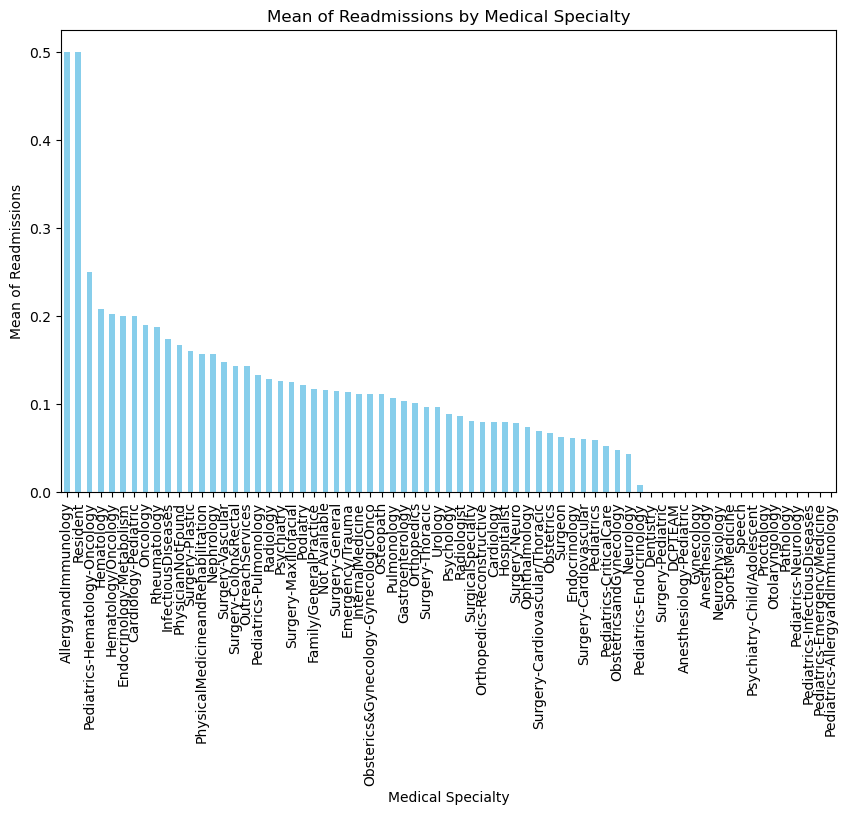

In [76]:
grouped_data = df_train.groupby('medical_specialty')['readmitted_binary'].mean()

import matplotlib.pyplot as plt

# Sort specialties based on mean values
sorted_data = grouped_data.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 6))
sorted_data.plot(kind='bar', color='skyblue')
plt.title('Mean of Readmissions by Medical Specialty')
plt.ylabel('Mean of Readmissions')
plt.xlabel('Medical Specialty')
plt.show()

In [ ]:
df_train['allergy_or_residence'] = df_train['medical_specialty'].apply(lambda x: 
                                                                              1 if (x == 'AllergyAndImmunology'
                                                                                   or x == 'Residence'
                                                                              else 0))
df_train['expired'] = df_train['discharge_disposition'].apply(lambda x: 1 if x == 'Expired' else 0)
df_train['transferred_rehub'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                        1 if x == 'Discharged/transferred to another rehab fac including rehab units of a hospital' else 0)
df_train['transferred_another_institution'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred to another type of inpatient care institution' else 0)
df_train['transferred_psychiatric_hospital'] = df_train['discharge_disposition'].apply(lambda x: 
                                                                      1 if x == 'Discharged/transferred/referred to a psychiatric hospital of psychiatric distinct part unit of a hospital	' else 0)
